In [1]:
import util
from importlib import reload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timezone
from numba import njit
import pickle
import os
import sqlite3
from dotenv import load_dotenv
import yfinance as yf
import strategies
load_dotenv()
util = reload(util)

In [ ]:

kraken_coin_data = util.get_exchange_coins('kraken')
kraken_coin_ids = [coin['coin_id'] for coin in kraken_coin_data]
kraken_symbols = [coin['base'].lower() for coin in kraken_coin_data]
tradable_kraken_coins = util.get_tradable_kraken_coins()

# TIME IS CLOSE TIME
all_data = util.get_all_ochl()

In [ ]:
btc_ohlc = all_data[all_data['symbol'] == 'btc'].drop(['symbol', 'coin_id', 'name'], axis=1).set_index('time_rank')
btc_ohlc[['open', 'high', 'low', 'close']] = np.log(btc_ohlc[['open', 'high', 'low', 'close']])
btc_ohlc.sort_index(inplace=True)
total_date_range = pd.date_range(start='2018-02-15 00:00:00+00:00', end=btc_ohlc.index[-1], freq='h', tz=timezone.utc)
btc_ohlc = btc_ohlc.reindex(total_date_range, method='ffill')
btc_ret = btc_ohlc['close'].diff() # if index is t, then ret[t] = close[t] - close[t-1]

In [86]:
in_sample_btc_ohlc = btc_ohlc.loc['2018-02-15':'2023-12-31']
out_of_sample_btc_ohlc = btc_ohlc.loc['2024-01-01':]
len(set(out_of_sample_btc_ohlc.index).difference(set(btc_ohlc.index)))+len(set(in_sample_btc_ohlc.index).difference(set(btc_ohlc.index)))  # should be empty

0

In [183]:
def channel_breakout_long(ohlc, entry_lookback=72, exit_lookback = 24):
    buy_signal = ohlc['close'] > ohlc['high'].rolling(window=entry_lookback-1).max().shift(1)
    sell_signal = ohlc['low'] < ohlc['low'].rolling(window=exit_lookback-1).min().shift(1)
    portfolio = np.zeros(len(ohlc))
    portfolio[buy_signal] = 1  # Buy signal
    portfolio[sell_signal] = -1  # Sell signal
    portfolio = pd.Series(portfolio, index=ohlc.index).replace(0, np.nan)  # Replace 0 with NaN for no position
    portfolio.ffill(inplace=True)  # Forward fill to maintain position until next signal
    portfolio.replace(-1, np.nan, inplace=True)  # Remove short positions
    portfolio.fillna(0, inplace=True)  # Fill NaN with 0 for no position
    return portfolio

In [184]:
portfolio = channel_breakout_long(in_sample_btc_ohlc, entry_lookback=72, exit_lookback=24)

Mean Turnover:  0.013008950934896997
Time Exposed Ratio: 0.9999611680646163
Time Exposed Sharpe Ratio: -0.7754866067963566
Time Exposed Sortino Ratio: -0.5209970884220064
Total Sharpe Ratio: -0.7754715490856842
Total Sortino Ratio: -0.5209768570967337
Profit Factor:  0.9499814074809525
Maximum Drawdown: 2.0808279416170903
Maximum Drawdown Duration (days): 1087.2916666666667


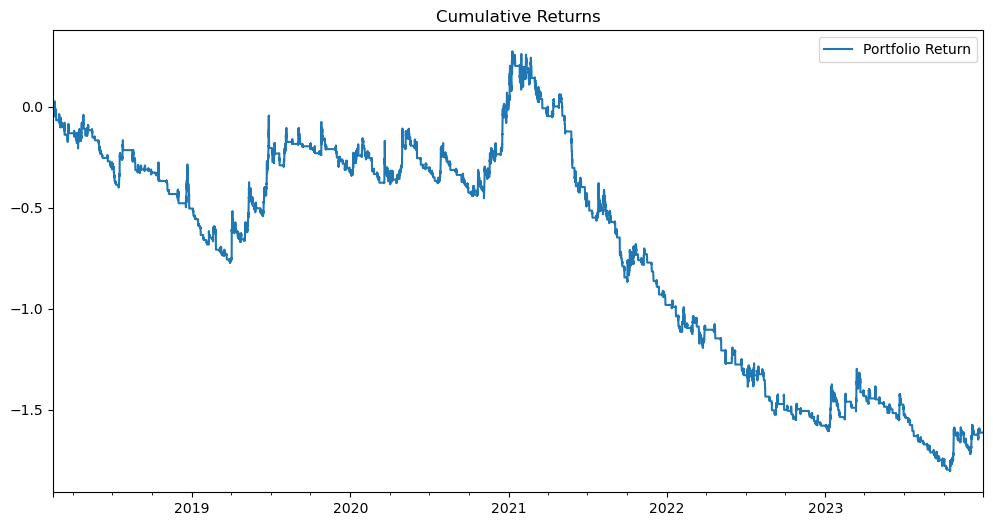

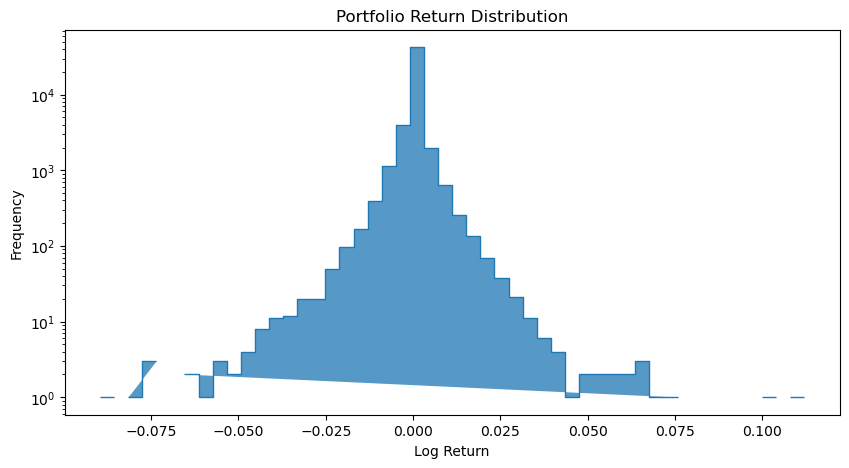

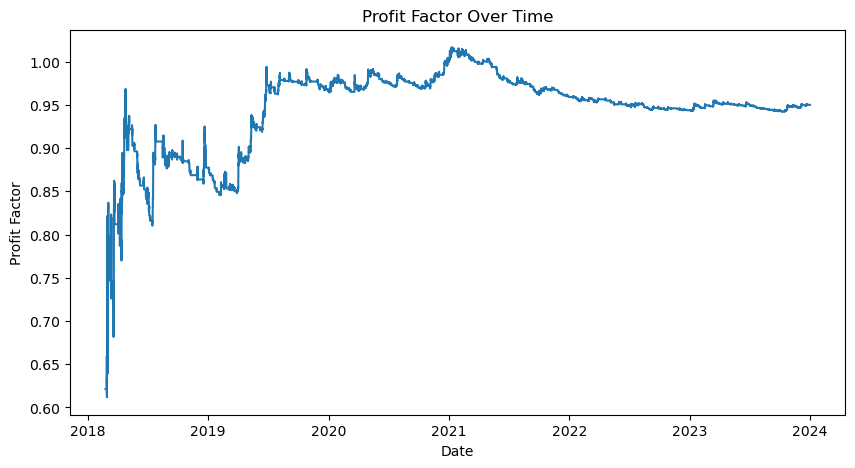

2018-02-15 00:00:00+00:00    NaN
2018-02-15 01:00:00+00:00    0.0
2018-02-15 02:00:00+00:00    0.0
2018-02-15 03:00:00+00:00    0.0
2018-02-15 04:00:00+00:00    0.0
                            ... 
2023-12-31 19:00:00+00:00    0.0
2023-12-31 20:00:00+00:00    0.0
2023-12-31 21:00:00+00:00    0.0
2023-12-31 22:00:00+00:00    0.0
2023-12-31 23:00:00+00:00    0.0
Freq: h, Length: 51504, dtype: float64

In [185]:
import seaborn as sns
def time_series_performance(portfolio_weights, returns, plot = False, to_bps = 46):
    to = portfolio_weights.diff().abs()
    print('Mean Turnover: ', to.mean())  # Mean turnover in basis points
    returns = returns.loc[portfolio_weights.index]  # Align returns with portfolio weights
    port_ret = portfolio_weights.shift(1) * returns  - to.shift(1)*to_bps*(10**(-4))# Shift weights to avoid lookahead bias
    print('Time Exposed Ratio:', port_ret.count()/len(port_ret))
    print('Time Exposed Sharpe Ratio:', (port_ret.mean() / port_ret.std()) * np.sqrt(365*24))  # Annualized Sharpe Ratio
    downside_std = port_ret[port_ret < 0].std()  # Downside standard deviation
    print('Time Exposed Sortino Ratio:', (port_ret.mean() / downside_std) * np.sqrt(365*24))  # Annualized Sortino Ratio
    port_ret.fillna(0, inplace=True)  # Fill NaN values with 0 for performance calculation
    sharpe = (port_ret.mean() / port_ret.std()) * np.sqrt(365*24)  # Annualized Sharpe Ratio
    print('Total Sharpe Ratio:', sharpe)  # Annualized Sharpe Ratio
    sortino = (port_ret.mean() / downside_std) * np.sqrt(365*24)
    print('Total Sortino Ratio:', sortino)  # Annualized Sortino Ratio
    profit = port_ret.where(port_ret > 0, 0).cumsum()
    loss = -port_ret.where(port_ret < 0, 0).cumsum()
    pf = profit/loss
    print('Profit Factor: ', profit.iloc[-1]/loss.iloc[-1] if loss.iloc[-1] != 0 else np.inf)  # Profit factor
    cum_port_ret = port_ret.cumsum()
    cum_max = cum_port_ret.cummax()
    mask = cum_port_ret < cum_max
    drawdown = cum_max - cum_port_ret
    max_drawdown = drawdown.max()
    drawdown_duration = mask.groupby((~mask).cumsum()).cumcount() + 1
    drawdown_duration[~mask] = 0
    max_drawdown_duration = drawdown_duration.max()/24
    print('Maximum Drawdown:', max_drawdown)
    print('Maximum Drawdown Duration (days):', max_drawdown_duration)
    if plot:
        plt.figure(figsize=(12, 6))
        port_ret.cumsum().plot(label='Portfolio Return')
        plt.title('Cumulative Returns')
        plt.legend()
        plt.show()

        # Plot 2: Return distribution
        plt.figure(figsize=(10, 5))
        sns.histplot(port_ret, bins=50, log_scale=(False, True), element='step').set(
            title='Portfolio Return Distribution',
            xlabel='Log Return', ylabel='Frequency')
        plt.show()
        pf_nonzero = pf[pf != 0]
        pf_trimmed = pf.loc[pf_nonzero.index[200:]]
        # Plot 3: Profit factor over time
        plt.figure(figsize=(10, 5))
        sns.lineplot(data=pf_trimmed)
        plt.title('Profit Factor Over Time')
        plt.xlabel('Date')
        plt.ylabel('Profit Factor')
        plt.show()
    return to
time_series_performance(portfolio, btc_ret, plot=True)
    